In [38]:


import pandas as pd
import numpy as np
import pymysql
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder, LabelEncoder



from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import plot_importance

pd.options.display.max_columns = None

In [212]:
host = "mudatabase.cr4neufosdwe.ap-northeast-2.rds.amazonaws.com"
port = 3306
username = "mu"
database = "mudatabase"
password = "munanodb"


In [213]:
conn = pymysql.connect(host = host , user = username, passwd = password, db = database, port = port,
                       use_unicode= True, charset= "utf8")

cursor = conn.cursor(pymysql.cursors.DictCursor)


In [214]:
query = "show tables"

cursor.execute(query)
cursor.fetchall()

[{'Tables_in_mudatabase': 'eco_macro'},
 {'Tables_in_mudatabase': 'oil'},
 {'Tables_in_mudatabase': 'population'},
 {'Tables_in_mudatabase': 'rent'},
 {'Tables_in_mudatabase': 'rent_re'},
 {'Tables_in_mudatabase': 'sell'},
 {'Tables_in_mudatabase': 'sell_re'}]

In [223]:
query = """

select
	aa.date,
	aa.gu,
	aa.dong,
	aa.area,
	aa.floor,
	aa.built,
	aa.doro,
	aa.tradetype,
	aa.price,
	aa.interest,
	aa.growth,
	aa.unemployment,
	aa.inflation,
	aa.stock,
	aa.house_debit,
	aa.ex_dallar as ex_dollar,
	aa.ex_yen,
	aa.household,
	aa.pop,
	aa.male_kor,
	aa.female_kor,
	aa.male_for,
	aa.female_for,
	aa.perhold,
	aa.senior,
	bb.oil as oil_price
	from
		(select
			date_format(a.date, "%Y-%m") as date,
			a.gu,
			a.dong,
			a.area,
			a.floor,
			a.built,
			a.doro,
			a.tradetype,
			a.price,
			b.interest,
			b.growth,
			b.unemployment,
			b.inflation,
			b.stock,
			b.house_debit,
			b.ex_dallar,
			b.ex_yen,
			c.household,
			c.pop,
			c.male_kor,
			c.female_kor,
			c.male_for,
			c.female_for,
			c.perhold,
			c.senior
		from
			sell_re as a
		left join
			eco_macro as b
		on
			date_format(a.date, "%Y-%m") = date_format(b.date, "%Y-%m")
        left join
			population as c
		on
			date_format(a.date, "%Y-%m") = date_format(c.date, "%Y-%m")
            and a.dong = c.dong) as aa
	left join mudatabase.oil as bb
	on
		aa.date = date_format(bb.date, "%Y-%m")
		and aa.dong = bb.dong
;

"""

cursor.execute(query)
result = cursor.fetchall()
raw_df = pd.DataFrame(result)

In [243]:
raw_df.drop(raw_df[raw_df["senior"].isna()].index).reset_index(drop = True)

,date,gu,dong,area,floor,built,doro,tradetype,price,interest,growth,unemployment,inflation,stock,house_debit,ex_dollar,ex_yen,household,pop,male_kor,female_kor,male_for,female_for,perhold,senior,oil_price
0,2016-01,광진구,구의2동,83.52,-1,1990,자양로44길 123,1,23500,1.5,1.14847,3.7,2.99390,1894.65,1223653.9,1201.67,1017.44,10481.0,25854.0,12516.0,13003.0,144.0,191.0,2.43,3177.0,1330.23
1,2016-01,중구,다산동,29.98,2,2015,동호로14길 11-17,1,26700,1.5,1.14847,3.7,2.99390,1894.65,1223653.9,1201.67,1017.44,6907.0,16063.0,7589.0,7963.0,226.0,285.0,2.25,2309.0,1729.29
2,2016-01,노원구,공릉2동,41.54,3,1993,공릉로34길 115,1,13000,1.5,1.14847,3.7,2.99390,1894.65,1223653.9,1201.67,1017.44,16803.0,45169.0,22105.0,22482.0,317.0,265.0,2.65,4292.0,1503.84
3,2016-01,영등포구,당산2동,24.97,14,2014,당산로 203,4,20000,1.5,1.14847,3.7,2.99390,1894.65,1223653.9,1201.67,1017.44,16354.0,36401.0,17053.0,18878.0,226.0,244.0,2.20,3836.0,1773.23
4,2016-01,관악구,난곡동,42.30,3,1992,법원단지34길 28,1,11000,1.5,1.14847,3.7,2.99390,1894.65,1223653.9,1201.67,1017.44,12868.0,30813.0,15373.0,14947.0,220.0,273.0,2.36,4419.0,1485.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346786,2021-06,강북구,미아동,34.95,-1,1993,솔매로 140-1,1,9500,0.5,1.29407,3.8,6.23812,3259.14,1805866.7,1121.30,1018.50,11739.0,22361.0,10564.0,11275.0,207.0,315.0,1.86,4425.0,1564.67
346787,2021-06,성북구,월곡2동,66.56,2,2002,화랑로18마길 9,1,24500,0.5,1.29407,3.8,6.23812,3259.14,1805866.7,1121.30,1018.50,9536.0,20040.0,9431.0,10137.0,222.0,250.0,2.05,3583.0,1583.62
346788,2021-06,성북구,종암동,34.31,2,2015,종암로9다길 21,1,26700,0.5,1.29407,3.8,6.23812,3259.14,1805866.7,1121.30,1018.50,17104.0,40539.0,19336.0,19713.0,542.0,948.0,2.28,6607.0,1564.22
346789,2021-06,동대문구,답십리1동,26.46,5,2012,사가정로 6,4,12500,0.5,1.29407,3.8,6.23812,3259.14,1805866.7,1121.30,1018.50,13052.0,29511.0,14080.0,15023.0,175.0,233.0,2.23,4030.0,NaN


## --

### 결측치

In [10]:
print(data.shape)
data.isna().sum().sum(), test.isna().sum().sum()


NameError: name 'data' is not defined

## EDA

In [11]:
plt.style.use('seaborn')
plt.rc("font", family='AppleGothic')
plt.rc('axes', unicode_minus = False)

numeric columns: 23
numeric columns: 21


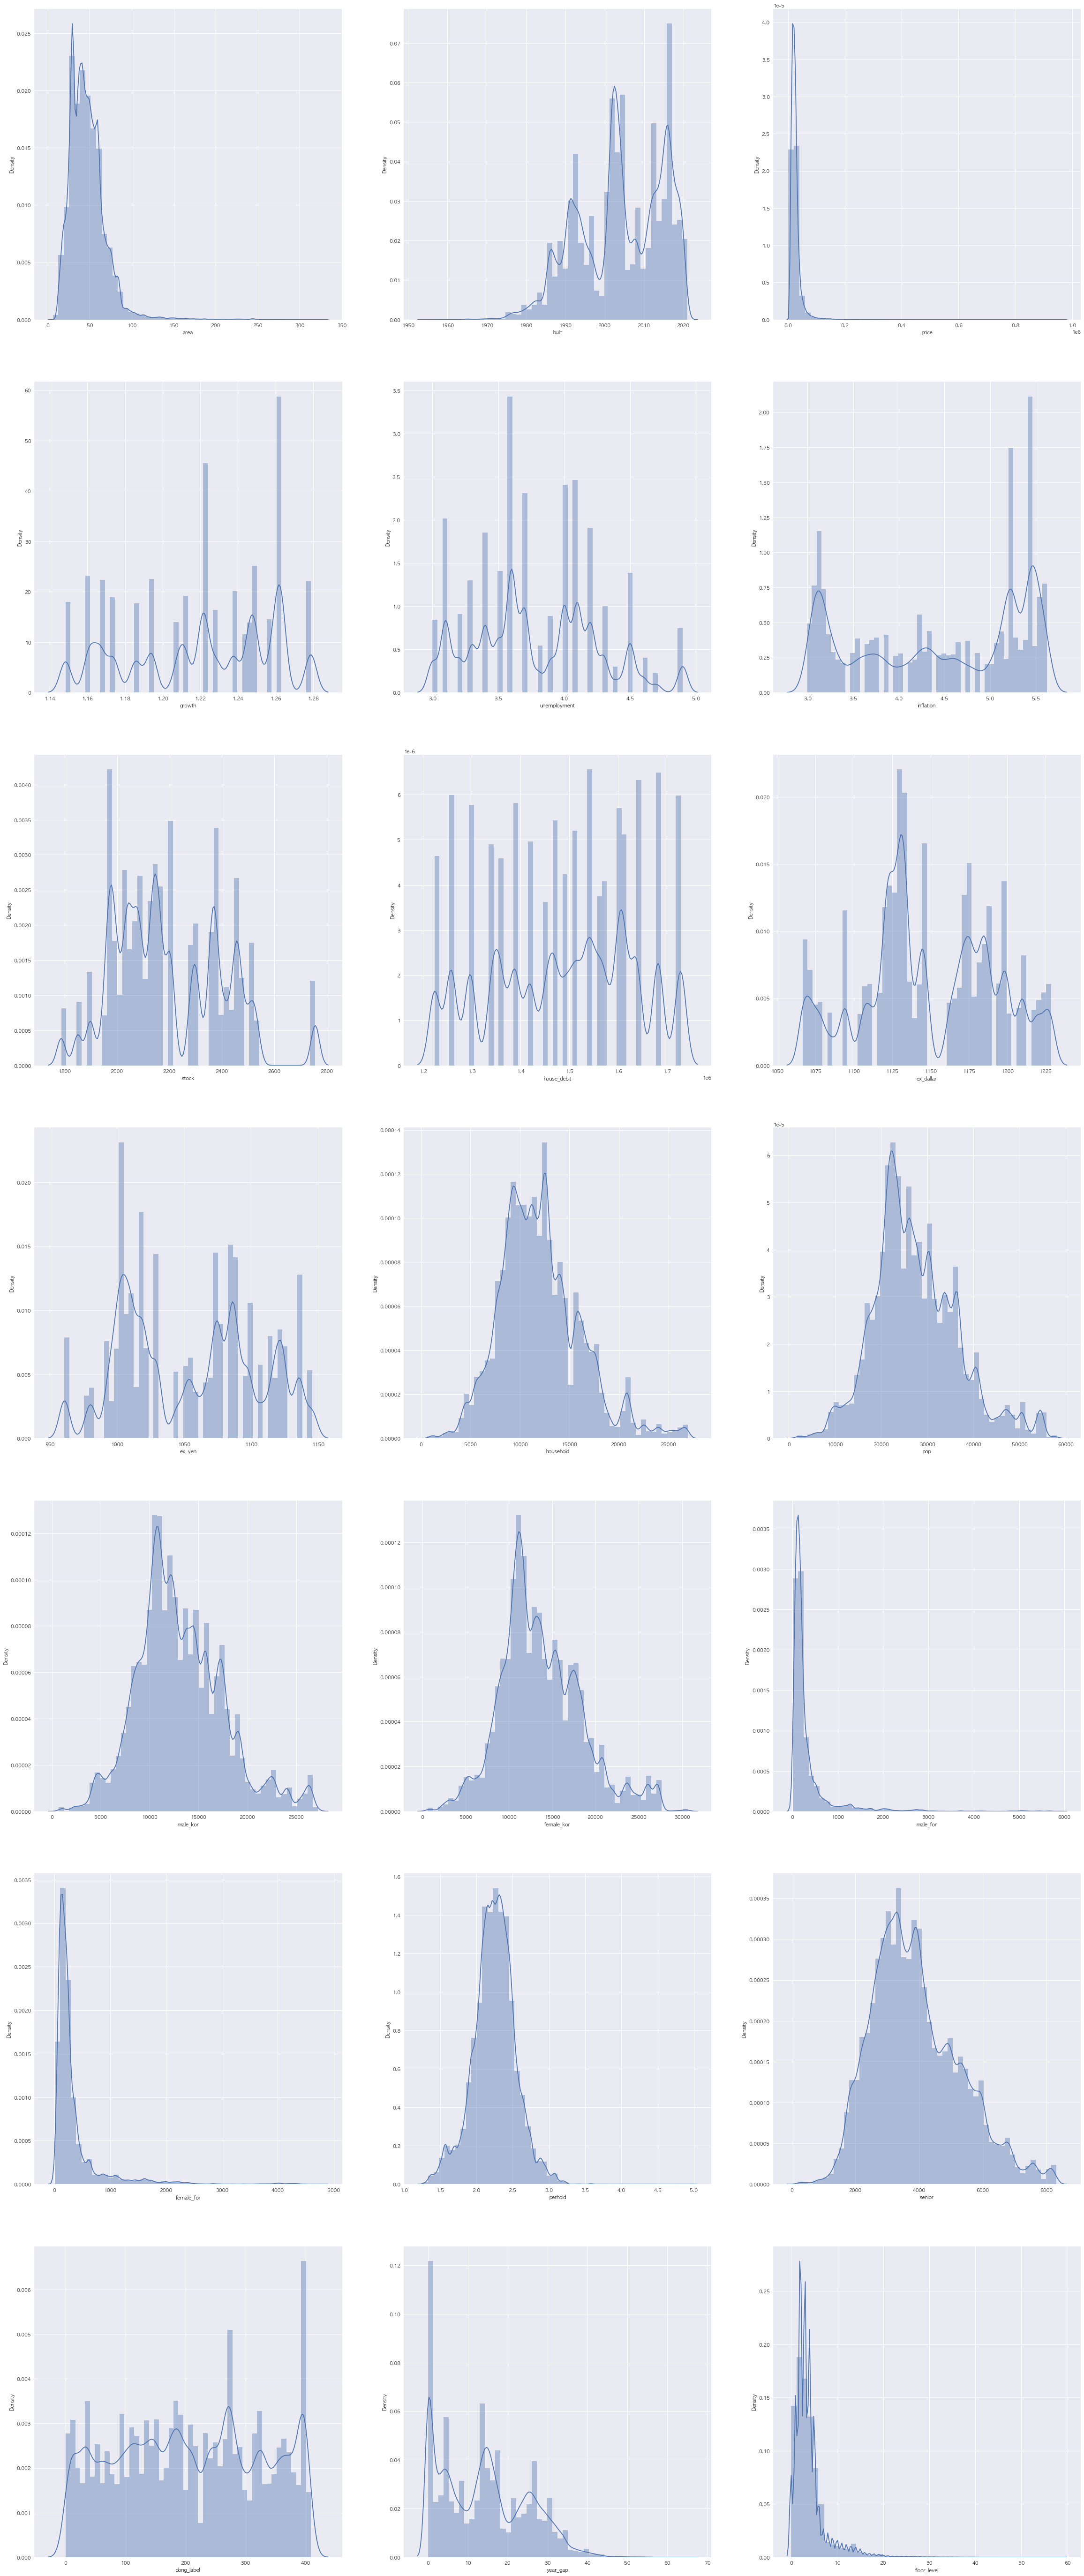

In [71]:
num_col = data.select_dtypes(exclude = ["object", "category"]).columns.to_list()
print("numeric columns:",len(num_col))
num_col.remove("year_trans")
num_col.remove("floor")
print("numeric columns:",len(num_col))

ncol = 3
nrow = int(len(num_col)/ncol)
fig, ax = plt.subplots(ncols = ncol,nrows =  nrow, sharex= False)
fig.set_size_inches(40, 100)
sns.plotting_context(font_scale = 3)


data_num = data[num_col]
for i in range(len(num_col)):
    sns.distplot(data_num.iloc[:,i], ax = ax[i//3, i%3])

    
    
# # # [doro_trans, interest] --> 카테고리로 추가
# # # look into: "built", "growth", "unemployment", "inflation", "stock", "house_debit"

53000.0

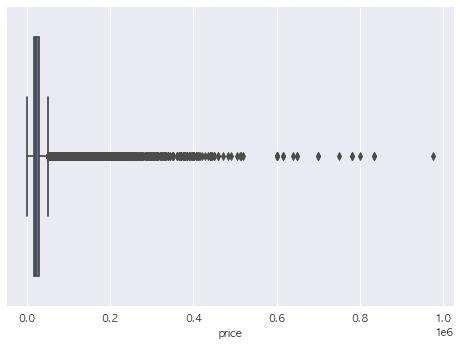

In [12]:
sns.boxplot(df["price"])

df["price"].quantile(0.95)

### 로그변환 변수

<AxesSubplot:xlabel='floor_level', ylabel='Density'>

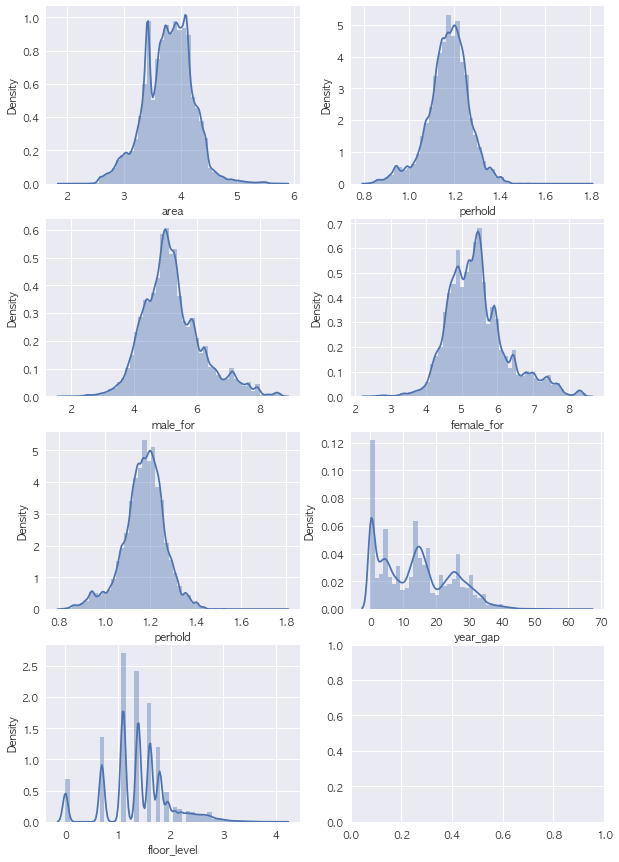

In [51]:
fig, ax = plt.subplots(4,2, sharex= False, figsize = (10,15))

sns.distplot(np.log1p(data["area"]), ax = ax[0,0])
sns.distplot(np.log1p(data["perhold"]), ax = ax[0,1])
sns.distplot(np.log1p(data["male_for"]), ax = ax[1,0])
sns.distplot(np.log1p(data["female_for"]), ax = ax[1,1])
# sns.distplot(np.log1p(data["perhold"]), ax = ax[2,0])

data["year_gap"] = data["year_gap"].apply(lambda x: 0 if x < 0 else x)
sns.distplot((data["year_gap"]), ax = ax[2,1])
# sns.distplot(np.log1p(target), ax = ax[3,0])

# data["floor_level"] = data["floor"].apply(lambda x: 0 if x < 0 else x)
sns.distplot(np.log1p(data["floor_level"]), ax = ax[3,0])

# ["area", "perhold", "male_for", "female_for", "perhold"]

<AxesSubplot:xlabel='year_gap', ylabel='Density'>

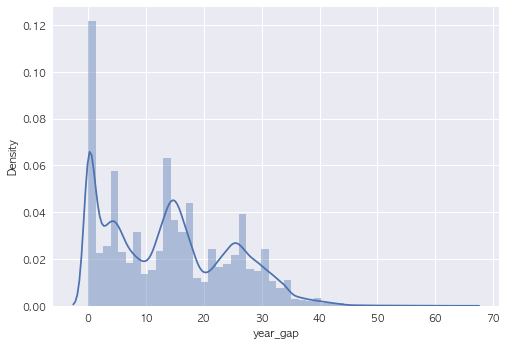

In [54]:
sns.distplot((data["year_gap"]))

train_data year_gap < 0: 29
test_data year_gap < 0: 0


<AxesSubplot:xlabel='floor', ylabel='price'>

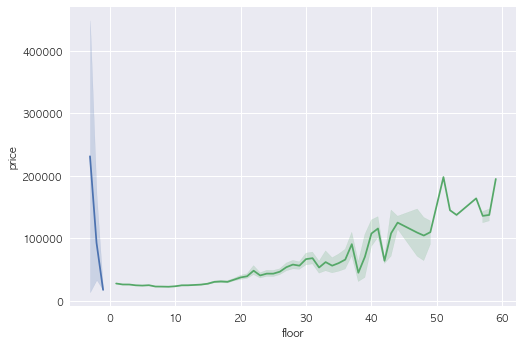

In [31]:
# floor, year_gap

data["floor"].value_counts()
data["year_gap"].value_counts()

print("train_data year_gap < 0:", len(data[data["year_gap"] < 0]))
print("test_data year_gap < 0:", len(test[test["year_gap"] < 0]))

# data[data["floor"] < 0]
# test[test["floor"] < 0]

# sns.lineplot(data = data, x = data["floor"], y = data["price"], ci= False)

sns.lineplot(data = data[data["floor"] < 0], x = "floor", y = "price")

sns.lineplot(data = data[data["floor"] >= 0], x = "floor", y = "price")

floor_level
btw_1_5     26074.561979
btw_6_20    24988.252697
over_20     51401.461461
under_0     17881.902184
Name: price, dtype: float64

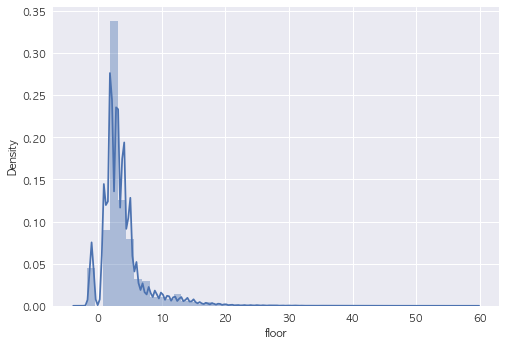

In [154]:
sns.distplot(data["floor"])
# data["floor"].value_counts(normalize = True)
                           
data["floor_level"] = data["floor"].apply(lambda x: get_floor_level(x))
data.groupby("floor_level")["price"].agg("mean")
# data["floor_level"].value_counts(normalize = True)

---

## 전처리

In [337]:
# 전체 데이터셋 처리 

def drop_raw_df_na(df):
    df_tmp = df.copy()
    df_tmp = df_tmp.drop(df_tmp[df_tmp["senior"].isna()].index).reset_index(drop = True)
    
    return df_tmp


# 평당 가격 변환
def get_perprice(df):
    df_tmp = df.copy()
    df_tmp["perprice"] = df_tmp["price"]/df_tmp["area"]
    df_tmp = df_tmp.drop("price", axis = 1)
    
    return df_tmp

def impute_na(df):
    df_tmp = df.copy()
    
    imp_mean = IterativeImputer(random_state= 42)
    tmp_col = df_tmp.select_dtypes(exclude = ["object", "category"]).columns.to_list()
    df_tmp[tmp_col] = imp_mean.fit_transform(df_tmp[tmp_col])
    
    return df_tmp


# 상위 k% row 제거
def drop_top_price(df, k):
    tmp_df = df.copy()
    top_price = tmp_df.groupby("gu")["price"].quantile(k).to_frame().T
    top_price_col = top_price.columns.to_list()


    for col in top_price_col: 
        gu_idx = tmp_df[tmp_df["gu"] == col]["price"].index
#         tmp_df.loc[gu_idx, "price"] = tmp_df.loc[gu_idx, "price"].apply(lambda x: top_price.loc[:, col][0] if x >= top_price.loc[:, col][0] else x)
        tmp_df.loc[gu_idx, "price"] = tmp_df.loc[gu_idx, "price"].apply(lambda x: np.nan if x >= top_price.loc[:, col][0] else x)
    tmp_df = tmp_df.dropna()
    tmp_df = tmp_df.reset_index(drop = True)
            
    return tmp_df

def get_pop_rate(df):
    tmp_df = df.copy()
    tmp_df['rate_male'] = tmp_df['male_kor'] / tmp_df['pop']
    tmp_df['rate_female'] = tmp_df['female_kor'] / tmp_df['pop']
    tmp_df['rate_male_f'] = tmp_df['male_for'] / tmp_df['pop']
    tmp_df['rate_female_f'] = tmp_df['female_for'] / tmp_df['pop']
    tmp_df['rate_senior'] = tmp_df['senior'] / tmp_df['pop']
    
    return tmp_df


# -----------------------------------------------------------------------------------------------
# 길, 로, 대로
def get_road(x) :
    con = x.split(' ')[0]
    if con[-2:] == '대로' :
        return 1
    elif con[-1:] == '로' :
        return 2
    else :
        return 3

# encoding -----------------------------------------------------------------------------------------------    
    
def categorize(df):
    df_tmp = df.copy()
    
    df_tmp["gu"] = df_tmp["gu"].astype("category")
    df_tmp["doro_trans"] = df_tmp["doro_trans"].astype("category")
    df_tmp["interest"] = df_tmp["interest"].astype("category")
    df_tmp["floor_level"]  = df_tmp["floor_level"].astype("category")
    df_tmp["tradetype"] = df_tmp["tradetype"].astype("category")
    df_tmp["dong"] = df_tmp["dong"].astype("category")
    
    return df_tmp


# scaling -----------------------------------------------------------------------------------------------

def get_log_scaled(df):
    
    df_tmp = df.copy()
    df_tmp = np.log1p(df_tmp)
    
    return df_tmp


# F.E.-----------------------------------------------------------------------------------------------

def get_year_trans(x):
    year_trans = int(x.split("-")[0])
    
    return year_trans

def get_year_gap(df):
    df_tmp = df.copy()
    df_tmp["year_gap"] = df_tmp["year_trans"] - df_tmp["built"]
    
    return df_tmp


def get_floor_level(x):
    if x < 0:
        return "under_0"
    elif x <= 5:
        return "btw_1_5"
    elif x <= 20:
        return "btw_6_20"
    else:
        return "over_20"
    

    
    

# 초기 데이터 학습용 검증용 분할; 
# 주의: 인코딩 작업 외 분포 확인 및 스케일링 작업은 분할 후 확인 
def split_test_train(df, preprocess = bool):
    
    
    global num_col, log_col, scale_col, cat_col
    
    df_tmp = df.copy()
    
    df_tmp = drop_raw_df_na(df_tmp)
    
    if preprocess == True:
        df_tmp = impute_na(df_tmp)
#         print("NA: ",df_tmp.isna().sum().sum())
#         print("oil drop", df_tmp.shape)
        df_tmp = drop_top_price(df_tmp, 0.80)
#         print("top price drop", df_tmp.shape)
        df_tmp = get_perprice(df_tmp)
#         print("perprice", df_tmp.shape)
#         le = LabelEncoder()
#         df_tmp["dong_label"] = le.fit_transform(df_tmp["dong"])
        
        df_tmp["doro_trans"] = df_tmp["doro"].apply(lambda x: get_road(x))
        df_tmp["year_trans"] = df_tmp["date"].apply(lambda x: get_year_trans(x))
        df_tmp = get_year_gap(df_tmp)

    
        df_tmp["floor_level"] = df_tmp["floor"].apply(lambda x: get_floor_level(x))
        df_tmp["floor"] = df_tmp["floor"] + 3
        
        df_tmp = get_pop_rate(df_tmp)
#         print(df_tmp.shape)
    
    
        df_tmp = categorize(df_tmp)

        
#         print(df_tmp.shape)

    test = df_tmp[df_tmp["date"].str.contains("2021")].copy()
#     print(df.shape)
#     print(test.shape)
    data = df_tmp.drop(test.index, axis = 0)
    data = data.reset_index(drop = True)
    test = test.reset_index(drop = True)
    
    target = data["perprice"]
    y_test_true = test["perprice"]
    
    data = data.drop("perprice", axis = 1)
    test = test.drop("perprice", axis = 1)
    
#     target = data["price"]
#     y_test_true = test["price"]
    
#     data = data.drop("price", axis = 1)
#     test = test.drop("price", axis = 1)

    num_col = data.select_dtypes(exclude = ["object","category"]).columns.to_list()
    
    log_col = ["area", "perhold", "male_for", "female_for", "floor"] 
    cat_col = data.select_dtypes(include = ["object", "category"]).columns.to_list()
    
    
#     data[log_col] = np.log1p(data[log_col])
#     test[log_col] = np.log1p(test[log_col])
    
    
    
    return data, target, test, y_test_true    


# ---------------------------------------------------------------------------------------------
    
def preprocess(X_train, X_valid, X_test):
    tmp_X_train = X_train.copy()
    tmp_X_valid = X_valid.copy()
    tmp_X_test = X_test.copy()
    
    tmp_X_train = tmp_X_train.reset_index(drop = True)
    tmp_X_valid = tmp_X_valid.reset_index(drop = True)
    tmp_X_test = tmp_X_test.reset_index(drop = True)
    
    
    # scale
    
    from sklearn.preprocessing import StandardScaler, RobustScaler
    
    sd_scaler = StandardScaler()
    rb_scaler = RobustScaler()
    
    tmp_X_train[num_col] = sd_scaler.fit_transform(tmp_X_train[num_col])
    tmp_X_valid[num_col] = sd_scaler.transform(tmp_X_valid[num_col])
    tmp_X_test[num_col] = sd_scaler.transform(tmp_X_test[num_col])
    
#     tmp_X_train[num_col] = rb_scaler.fit_transform(tmp_X_train[num_col])
#     tmp_X_valid[num_col] = rb_scaler.transform(tmp_X_valid[num_col])
#     tmp_X_test[num_col] = rb_scaler.transform(tmp_X_test[num_col])
    
#     print(num_col)

    

    
    
    final_col = [
#                  'date', 
                 'gu', 
                 'dong', 
                 'area',
                 'floor',
#                  'built',
#                  'doro',
                 'tradetype', 
                 'interest',
#                  'growth',
                 'unemployment',
                 'inflation',
                 'stock',
#                  'house_debit',
                 'ex_dollar',
#                  'ex_yen',
#                  'household',
                 'pop',
#                  'male_kor',
#                  'female_kor',
#                  'male_for',
#                  'female_for',
                 'rate_male',
                 'rate_female',
#                  'rate_male_f', 
                 'rate_female_f',
                 'rate_senior',
                 'perhold',
#                  'senior',
#                  'dong_label',
                 'doro_trans',
#                  'year_trans',
                 'year_gap',
                 'floor_level',
                 'oil_price'
                 
                ]

#     "senior", "rate_male_f", "household", "ex_yen", "house_debit"
    
    
    return tmp_X_train[final_col], tmp_X_valid[final_col], tmp_X_test[final_col]
    



<AxesSubplot:xlabel='area', ylabel='price'>

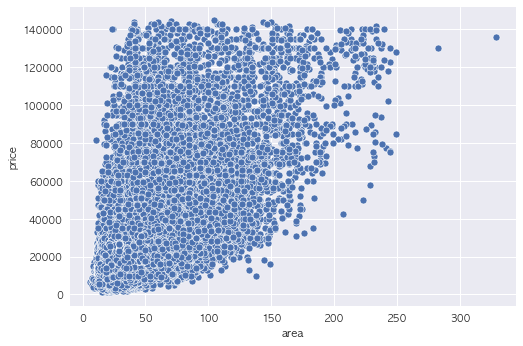

In [258]:
sns.scatterplot(data = d, x = "area", y = "price", ci = None)
# sns.lineplot(data = d, x = "area", y = "price", ci = None)

<AxesSubplot:>

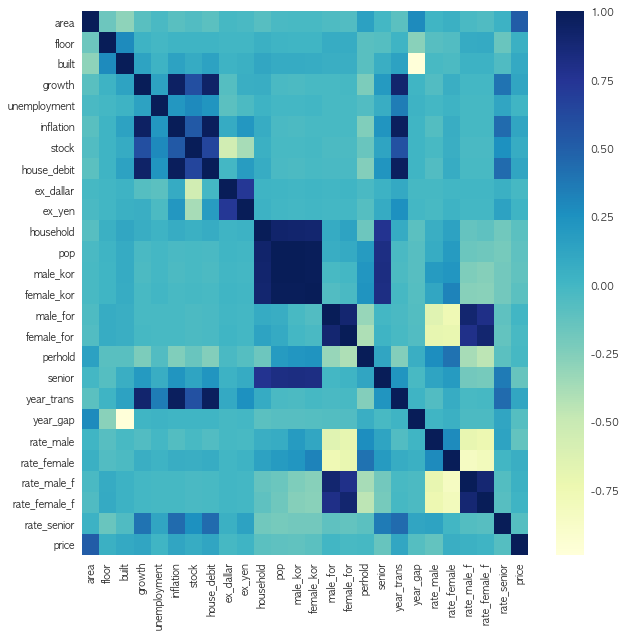

In [298]:
plt.figure(figsize = (10,10))
sns.heatmap(corr, cmap = "YlGnBu")

In [242]:
def testing(df):
    df_tmp = df.copy()
    df_tmp = drop_top_price(df, 0.97)

#     df_tmp = get_perprice(df_tmp)

    #         le = LabelEncoder()
    #         df_tmp["dong_label"] = le.fit_transform(df_tmp["dong"])

    df_tmp["doro_trans"] = df_tmp["doro"].apply(lambda x: get_road(x))
    df_tmp["year_trans"] = df_tmp["date"].apply(lambda x: get_year_trans(x))
    df_tmp = get_year_gap(df_tmp)


    df_tmp["floor_level"] = df_tmp["floor"].apply(lambda x: get_floor_level(x))
    df_tmp["floor"] = df_tmp["floor"] + 3

    df_tmp = get_pop_rate(df_tmp)


    df_tmp = categorize(df_tmp)
    
    return df_tmp


d = testing(df)



### function test

In [114]:
data_tmp, target, test_tmp, y_test_true = split_test_train(df, True)

print(data_tmp.shape,test_tmp.shape, y_test_true.shape)

NA:  0
oil drop (346791, 26)
top price drop (311489, 26)
perprice (311489, 26)
(277397, 34) (34092, 34) (34092,)


In [637]:
print(df.shape)
print(data_tmp.shape[0] + test_tmp.shape[0])

df.shape[0] - (data_tmp.shape[0] + test_tmp.shape[0])

(346791, 26)
234165


112626

In [116]:
from sklearn.model_selection import train_test_split

xtrain, xvalid, ytrain, yvalid = train_test_split(data_tmp, target, test_size = 0.3, shuffle = True, random_state = 42)

print(xtrain.shape, xvalid.shape, test_tmp.shape)

xtrain, xvalid, xtest = preprocess(xtrain, xvalid, test_tmp)

print(xtrain.shape, xvalid.shape, xtest.shape)

(194177, 34) (83220, 34) (34092, 34)
(194177, 26) (83220, 26) (34092, 26)


<AxesSubplot:>

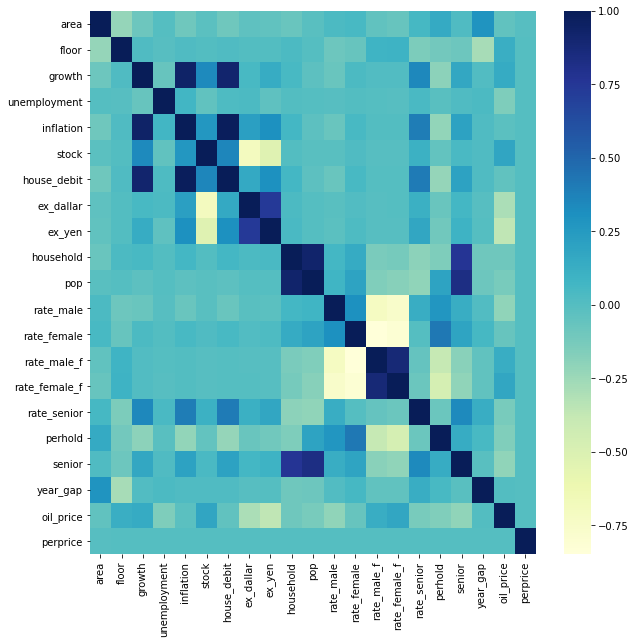

In [156]:
graph_col = ['gu'
            , 'dong'
            , 'area'
            , 'floor'
            , 'tradetype'
            , 'interest'
            , 'growth'
            , 'unemployment'
            , 'inflation'
            , 'stock'
            , 'house_debit'
            , 'ex_dallar'
            , 'ex_yen'
            , 'household'
            , 'pop'
            , 'rate_male'
            , 'rate_female'
            , 'rate_male_f'
            , 'rate_female_f'
            , 'rate_senior'
            , 'perhold'
            , 'senior'
            , 'doro_trans'
            , 'year_gap'
            , 'floor_level'
            , 'oil_price'
        ]

# "senior", "rate_male_f", "household", "ex_yen","house_debit"

corr = pd.concat([xtrain[graph_col], target], axis =1 ).corr()
corr
plt.figure(figsize = (10,10))
sns.heatmap(corr, cmap = "YlGnBu")


<AxesSubplot:>

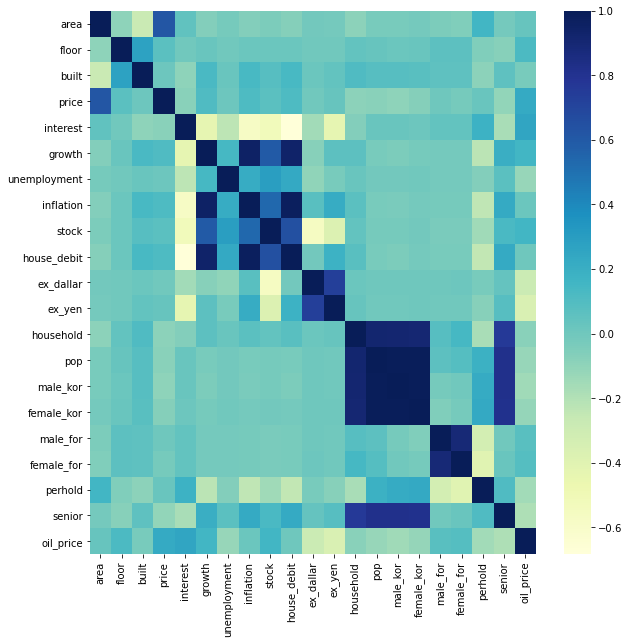

In [133]:
corr = graph_df.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, cmap = "YlGnBu")

---

## Modeling

In [272]:
df = drop_raw_df_na(raw_df)
df = impute_na(df)


,date,gu,dong,area,floor,built,doro,tradetype,price,interest,growth,unemployment,inflation,stock,house_debit,ex_dollar,ex_yen,household,pop,male_kor,female_kor,male_for,female_for,perhold,senior,oil_price
0,2016-01,광진구,구의2동,83.52,-1.0,1990.0,자양로44길 123,1,23500.0,1.5,1.14847,3.7,2.99390,1894.65,1223653.9,1201.67,1017.44,10481.0,25854.0,12516.0,13003.0,144.0,191.0,2.43,3177.0,1330.230000
1,2016-01,중구,다산동,29.98,2.0,2015.0,동호로14길 11-17,1,26700.0,1.5,1.14847,3.7,2.99390,1894.65,1223653.9,1201.67,1017.44,6907.0,16063.0,7589.0,7963.0,226.0,285.0,2.25,2309.0,1729.290000
2,2016-01,노원구,공릉2동,41.54,3.0,1993.0,공릉로34길 115,1,13000.0,1.5,1.14847,3.7,2.99390,1894.65,1223653.9,1201.67,1017.44,16803.0,45169.0,22105.0,22482.0,317.0,265.0,2.65,4292.0,1503.840000
3,2016-01,영등포구,당산2동,24.97,14.0,2014.0,당산로 203,4,20000.0,1.5,1.14847,3.7,2.99390,1894.65,1223653.9,1201.67,1017.44,16354.0,36401.0,17053.0,18878.0,226.0,244.0,2.20,3836.0,1773.230000
4,2016-01,관악구,난곡동,42.30,3.0,1992.0,법원단지34길 28,1,11000.0,1.5,1.14847,3.7,2.99390,1894.65,1223653.9,1201.67,1017.44,12868.0,30813.0,15373.0,14947.0,220.0,273.0,2.36,4419.0,1485.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346786,2021-06,강북구,미아동,34.95,-1.0,1993.0,솔매로 140-1,1,9500.0,0.5,1.29407,3.8,6.23812,3259.14,1805866.7,1121.30,1018.50,11739.0,22361.0,10564.0,11275.0,207.0,315.0,1.86,4425.0,1564.670000
346787,2021-06,성북구,월곡2동,66.56,2.0,2002.0,화랑로18마길 9,1,24500.0,0.5,1.29407,3.8,6.23812,3259.14,1805866.7,1121.30,1018.50,9536.0,20040.0,9431.0,10137.0,222.0,250.0,2.05,3583.0,1583.620000
346788,2021-06,성북구,종암동,34.31,2.0,2015.0,종암로9다길 21,1,26700.0,0.5,1.29407,3.8,6.23812,3259.14,1805866.7,1121.30,1018.50,17104.0,40539.0,19336.0,19713.0,542.0,948.0,2.28,6607.0,1564.220000
346789,2021-06,동대문구,답십리1동,26.46,5.0,2012.0,사가정로 6,4,12500.0,0.5,1.29407,3.8,6.23812,3259.14,1805866.7,1121.30,1018.50,13052.0,29511.0,14080.0,15023.0,175.0,233.0,2.23,4030.0,1567.956779


In [ ]:
def drop_top_price(df, k):
    tmp_df = df.copy()
    top_price = tmp_df.groupby("gu")["price"].quantile(k).to_frame().T
    top_price_col = top_price.columns.to_list()


    for col in top_price_col: 
        gu_idx = tmp_df[tmp_df["gu"] == col]["price"].index
        tmp_df.loc[gu_idx, "price"] = tmp_df.loc[gu_idx, "price"].apply(lambda x: top_price.loc[:, col][0] if x >= top_price.loc[:, col][0] else x)
        
#     tmp_df = tmp_df.dropna()
    tmp_df = tmp_df.reset_index(drop = True)
            
    return tmp_df

In [338]:
data, target, test, y_test_true = split_test_train(raw_df, True)
print(data.shape, test.shape)

n_splits = 4
kf = KFold(n_splits, shuffle= True, random_state= 42)
oof_pred = np.zeros([y_test_true.shape[0], ])
rmse_score = []


for i, (trn_idx, val_idx) in enumerate(kf.split(data, target)):
    X_train, y_train = data.iloc[trn_idx,:], target[trn_idx]
    X_valid, y_valid = data.iloc[val_idx,:], target[val_idx]


    X_train, X_valid, X_test = preprocess(X_train, X_valid, test)
    
    
    from lightgbm import LGBMRegressor
    model = LGBMRegressor(
                           n_jobs= -1,
                           random_state   = 42)
    
    
    model.fit(X_train, y_train,
              eval_set=[[X_train, y_train], [X_valid, y_valid]],
              eval_metric= "rmse",
              early_stopping_rounds=100,
              verbose=100
             )
    
    rmse_score.append(mean_squared_error(y_valid, model.predict(X_valid), squared = False))
    oof_pred += model.predict(X_test) / n_splits
    
    print("Fold {0}, train rmse: {1}, valid rmse: {2}".format(i, 
                                                              mean_squared_error(y_train, model.predict(X_train), squared = False),
                                                              mean_squared_error(y_valid, model.predict(X_valid), squared = False)))
    
    cv_loss = np.mean(rmse_score)

print("Cross Validation Score : {:.4f}".format(np.mean(cv_loss)))

(248017, 34) (28074, 34)
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 82.4112	training's l2: 6791.6	valid_1's rmse: 85.3329	valid_1's l2: 7281.7
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 82.4112	training's l2: 6791.6	valid_1's rmse: 85.3329	valid_1's l2: 7281.7
Fold 0, train rmse: 82.41116376480724, valid rmse: 85.33290386122161
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 82.0234	training's l2: 6727.83	valid_1's rmse: 87.446	valid_1's l2: 7646.8
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 82.0234	training's l2: 6727.83	valid_1's rmse: 87.446	valid_1's l2: 7646.8
Fold 1, train rmse: 82.02336759045977, valid rmse: 87.44599739607699
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 82.0619	training's l2: 6734.16	valid_1's rmse: 85.865	valid_1's l2: 7372.8
Did not meet early stopping. Best iteration is:
[100]	training's 

In [309]:
oof_pred

array([1156.75143513, 1137.61447382,  487.81366677, ...,  653.78424575,
        552.91879481,  849.12957645])

In [339]:
mean_squared_error(y_test_true, oof_pred, squared = False)

125.39447875429413

In [340]:
y_test_true

0        1383.589138
1        1325.088548
2         494.953416
3        1499.167129
4        1195.218418
            ...     
28069     271.816881
28070     368.088942
28071     778.198776
28072     472.411187
28073    1001.335113
Name: perprice, Length: 28074, dtype: float64

In [341]:
print(r2_score(y_test_true, oof_pred))
# print(r2_score(np.expm1(y_test_true), np.expm1(oof_pred)))

0.8315198225168791


<AxesSubplot:xlabel='importance', ylabel='feature'>

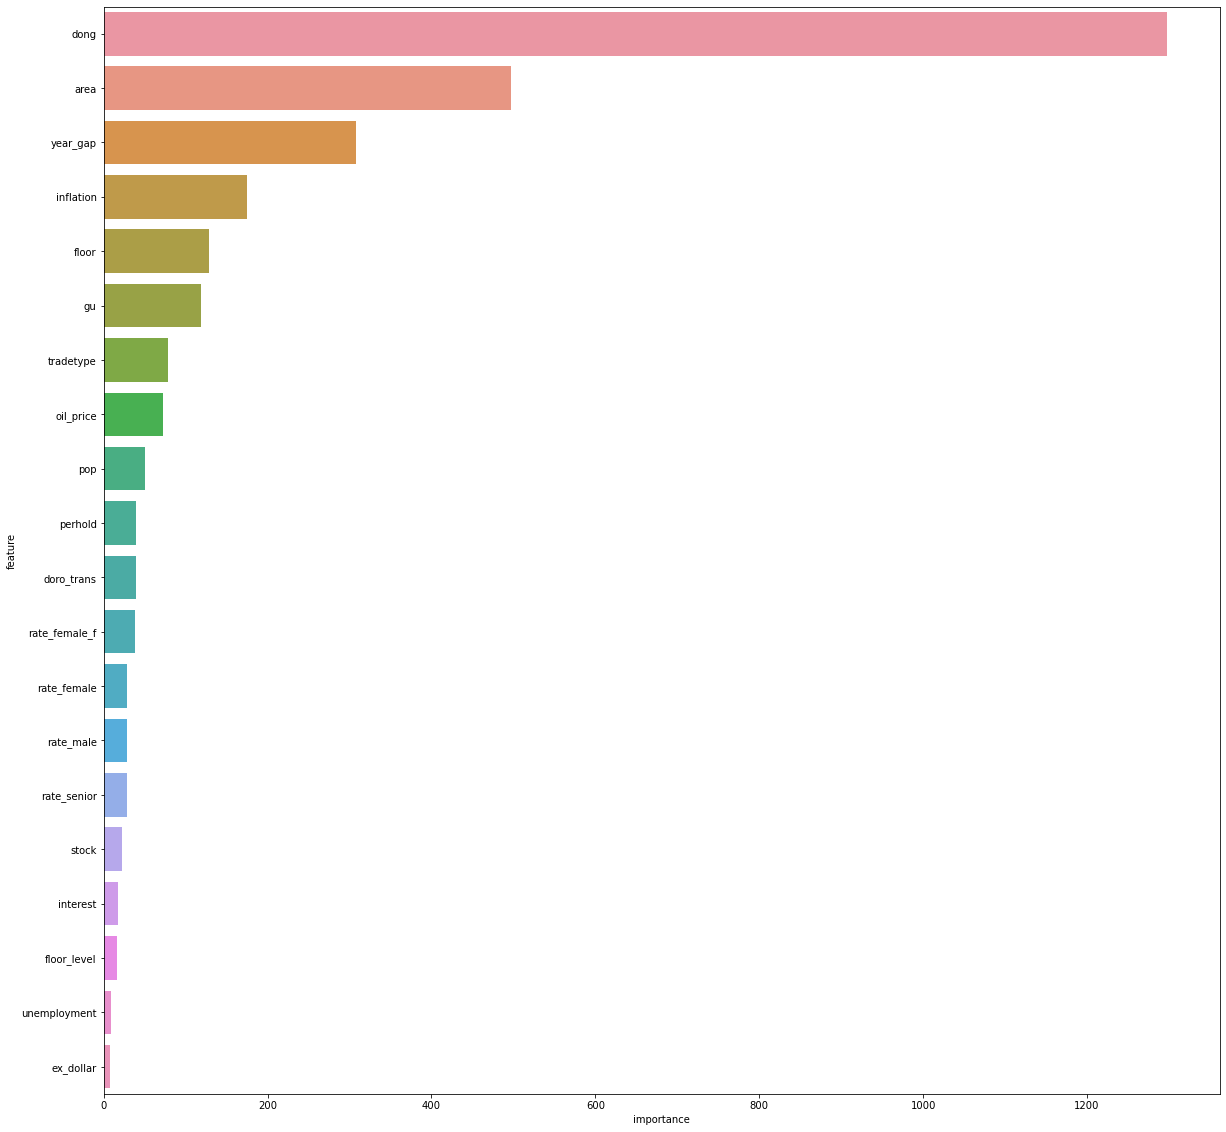

In [344]:
feature_importance = pd.DataFrame([model.feature_importances_, model.feature_name_], index= ["importance", "feature"]).T
feature_importance = feature_importance.sort_values("importance", ascending = False)
plt.figure(figsize = (20,20))
sns.barplot(data = feature_importance, x = "importance", y = "feature")

In [85]:
# k = 0.95

print("상위 0.05% 제거시 RMSE: {0}, 평당 RMSE:{1}".format(mean_squared_error((y_test_true * test["area"]),(oof_pred * test["area"]), squared = False), 
                                                  mean_squared_error(y_test_true, oof_pred, squared = False)))


상위 0.05% 제거시 RMSE: 5838.768810066523, 평당 RMSE:156.06803010636207


In [92]:
# k = 0.9

print("상위 0.1% 제거시 RMSE: {0}, 평당 RMSE:{1}".format(mean_squared_error((y_test_true * test["area"]),(oof_pred * test["area"]), squared = False), 
                                                  mean_squared_error(y_test_true, oof_pred, squared = False)))


상위 0.1% 제거시 RMSE: 4875.719147615414, 평당 RMSE:142.86065912190313


In [205]:
# k = 0.9, dong => 카테고리

print("상위 0.1% 제거시 RMSE: {0}, 평당 RMSE:{1}".format(mean_squared_error((y_test_true * test["area"]),(oof_pred * test["area"]), squared = False), 
                                                  mean_squared_error(y_test_true, oof_pred, squared = False)))


상위 0.1% 제거시 RMSE: 4760.008681153015, 평당 RMSE:140.77429528482935


---

### K-fold, selection of K

In [442]:

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import plot_importance

rmse_scores = []
for j in range(2, 7):

    n_splits = j
    kf = KFold(n_splits, shuffle= True, random_state= 42)
    oof_pred = np.zeros([y_test_true.shape[0], ])
    rmse_score = []


    for i, (trn_idx, val_idx) in enumerate(kf.split(data, target)):
        X_train, y_train = data.iloc[trn_idx,:], target[trn_idx]
        X_valid, y_valid = data.iloc[val_idx,:], target[val_idx]


        X_train, X_valid, X_test = preprocess(X_train, X_valid, test)


        from lightgbm import LGBMRegressor
        model = LGBMRegressor( 
                               n_jobs = -1,
                               random_state = 42)


        model.fit(X_train, y_train,
                  eval_set=[[X_train, y_train], [X_valid, y_valid]],
                  eval_metric= "rmse",
                  early_stopping_rounds=100,
                  verbose=100
                 )

        rmse_score.append(mean_squared_error(y_valid, model.predict(X_valid), squared = False))
        oof_pred += model.predict(X_test) / j
        if oof_pred[0] == np.inf:
            print(j)
            break

        print("Fold {0}, train rmse: {1}, valid rmse: {2}".format(i, 
                                                                  mean_squared_error(y_train, model.predict(X_train), squared = False),
                                                                  mean_squared_error(y_valid, model.predict(X_valid), squared = False)))

        cv_loss = np.mean(rmse_score)
        rmse_list = list(rmse_score)

    print("Cross Validation Score : {:.4f}".format(np.mean(cv_loss)))
    rmse_scores.append(rmse_list)

['area', 'floor', 'built', 'growth', 'unemployment', 'inflation', 'stock', 'house_debit', 'ex_dallar', 'ex_yen', 'household', 'pop', 'male_kor', 'female_kor', 'male_for', 'female_for', 'perhold', 'senior', 'year_trans', 'year_gap', 'rate_male', 'rate_female', 'rate_male_f', 'rate_female_f', 'rate_senior']
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 91.1682	training's l2: 8311.64	valid_1's rmse: 97.6313	valid_1's l2: 9531.87
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 91.1682	training's l2: 8311.64	valid_1's rmse: 97.6313	valid_1's l2: 9531.87
Fold 0, train rmse: 91.16818979663817, valid rmse: 97.63129145302435
['area', 'floor', 'built', 'growth', 'unemployment', 'inflation', 'stock', 'house_debit', 'ex_dallar', 'ex_yen', 'household', 'pop', 'male_kor', 'female_kor', 'male_for', 'female_for', 'perhold', 'senior', 'year_trans', 'year_gap', 'rate_male', 'rate_female', 'rate_male_f', 'rate_female_f', 'rate_senior']
Trainin

In [443]:
rmse_scores = pd.DataFrame(rmse_scores, index= ["k=2", "k=3","k=4","k=5","k=6"]).T
rmse_scores

,k=2,k=3,k=4,k=5,k=6
0,97.631291,96.432132,96.238072,95.948017,96.036903
1,98.562836,96.584504,96.261064,95.591364,95.761936
2,NaN,97.948397,96.241337,96.216668,96.259237
3,NaN,NaN,97.895769,97.785576,95.631516
4,NaN,NaN,NaN,96.920332,98.184616
5,NaN,NaN,NaN,NaN,96.528226


In [445]:
for k in rmse_scores.columns:
    print("{0}, cv_score mean: {1:.5f}, cv_score variance: {2:.5f}".format(
          k, np.mean(rmse_scores[k]), np.var(rmse_scores[k])))

k=2, cv_score mean: 98.09706, cv_score variance: 0.21694
k=3, cv_score mean: 96.98834, cv_score variance: 0.46472
k=4, cv_score mean: 96.65906, cv_score variance: 0.50989
k=5, cv_score mean: 96.49239, cv_score variance: 0.60794
k=6, cv_score mean: 96.40041, cv_score variance: 0.72511


In [189]:


for k in rmse_scores.columns:
    print("{0}, cv_score mean: {1:.5f}, cv_score variance: {2:.5f}".format(
          k, np.mean(rmse_scores[k]), np.var(rmse_scores[k])))

k=5, cv_score mean: 96.61847, cv_score variance: 0.65013
k=6, cv_score mean: 96.44464, cv_score variance: 0.58930
k=7, cv_score mean: 96.23827, cv_score variance: 1.17761
k=8, cv_score mean: 96.17915, cv_score variance: 1.05970
k=9, cv_score mean: 96.14092, cv_score variance: 1.49241
k=10, cv_score mean: 96.10624, cv_score variance: 1.63874


In [ ]:
['rate_female', 'house_debit', 'growth', 'ex_yen', 'senior', 'rate_male_f', 'male_kor', 'rate_male', 'unemployment', 'pop', 'rate_senior', 'year_trans', 'inflation', 'rate_female_f', 'female_kor', 'built', 'household', 'ex_dallar', 'stock', 'year_gap']

---

### Catboost

In [347]:
#!pip install catboost

     |████████████████████████████████| 12.9 MB 6.1 MB/s eta 0:00:01


In [348]:

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import plot_importance

from catboost import CatBoostRegressor
cat_ref = CatBoostRegressor()

In [ ]:
data, target, test, y_test_true = split_test_train(raw_df, True)
print(data.shape, test.shape)

In [376]:
data["interest"]

0         1.5
1         1.5
2         1.5
3         1.5
4         1.5
         ... 
248012    0.5
248013    0.5
248014    0.5
248015    0.5
248016    0.5
Name: interest, Length: 248017, dtype: category
Categories (5, float64): [0.50, 0.75, 1.25, 1.50, 1.75]

In [382]:
# data, target, test, y_test_true = split_test_train(raw_df, True)
data["interest"] = data["interest"].astype("float")
test["interest"] = test["interest"].astype("float")

cat_feat = ['gu', 'dong', 'tradetype', 'doro_trans', 'floor_level']
print(data.shape, test.shape)

n_splits = 4
kf = KFold(n_splits, shuffle= True, random_state= 42)
oof_pred = np.zeros([y_test_true.shape[0], ])
rmse_score = []


for i, (trn_idx, val_idx) in enumerate(kf.split(data, target)):
    X_train, y_train = data.iloc[trn_idx,:], target[trn_idx]
    X_valid, y_valid = data.iloc[val_idx,:], target[val_idx]


    X_train, X_valid, X_test = preprocess(X_train, X_valid, test)
    
    
    from catboost import CatBoostRegressor
    model = CatBoostRegressor(
                                eval_metric = "RMSE"
                              , random_state   = 42)
    
    
    model.fit(X_train, y_train,
              eval_set=(X_valid, y_valid),
              early_stopping_rounds=100,
              verbose=100,
              cat_features = cat_feat
             )
    
    rmse_score.append(mean_squared_error(y_valid, model.predict(X_valid), squared = False))
    oof_pred += model.predict(X_test) / n_splits
    
    print("Fold {0}, train rmse: {1}, valid rmse: {2}".format(i, 
                                                              mean_squared_error(y_train, model.predict(X_train), squared = False),
                                                              mean_squared_error(y_valid, model.predict(X_valid), squared = False)))
    
    cv_loss = np.mean(rmse_score)

print("Cross Validation Score : {:.4f}".format(np.mean(cv_loss)))

(248017, 34) (28074, 34)


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.115668
0:	learn: 225.3740550	test: 223.5665051	best: 223.5665051 (0)	total: 49ms	remaining: 48.9s
100:	learn: 104.1033399	test: 102.6796060	best: 102.6796060 (100)	total: 3.57s	remaining: 31.8s
200:	learn: 96.4428047	test: 95.9964283	best: 95.9964283 (200)	total: 7.21s	remaining: 28.6s
300:	learn: 92.1593146	test: 92.4816170	best: 92.4816170 (300)	total: 10.8s	remaining: 25s
400:	learn: 89.3069530	test: 90.2329285	best: 90.2329285 (400)	total: 14.4s	remaining: 21.5s
500:	learn: 87.3231176	test: 88.7817359	best: 88.7817359 (500)	total: 18.2s	remaining: 18.1s
600:	learn: 85.5283203	test: 87.4795145	best: 87.4795145 (600)	total: 22s	remaining: 14.6s
700:	learn: 83.9133005	test: 86.3831982	best: 86.3831982 (700)	total: 25.8s	remaining: 11s
800:	learn: 82.6224075	test: 85.5348721	best: 85.5348721 (800)	total: 29.8s	remaining: 7.4s
900:	learn: 81.5066650	test: 84.7833519	best: 84.7833519 (900)	total: 33.6s	remaining: 3.69s
999:	learn: 80.4545186	test: 84.0461317	best: 

In [383]:
mean_squared_error(y_test_true, oof_pred, squared = False)

117.93065157755231

In [384]:
y_test_true

0        1383.589138
1        1325.088548
2         494.953416
3        1499.167129
4        1195.218418
            ...     
28069     271.816881
28070     368.088942
28071     778.198776
28072     472.411187
28073    1001.335113
Name: perprice, Length: 28074, dtype: float64